In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import tensorflow_datasets as tfds

print(tf.__version__)

2.6.0


In [2]:
print(len(tf.config.experimental.list_physical_devices('GPU')))

1


In [3]:
#IMPORTAÇÃO E NORRMALIZAÇÃO
(x_train, y_train), (x_test,y_test) = keras.datasets.cifar10.load_data()

x_train = x_train.astype(float)/255
x_test = x_test.astype(float)/255

#CRIAR DATASET
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(50000).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

170508288/170498071 [==============================] - 2s 0us/step


In [4]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    figure(figsize=(10, 7), dpi=80)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm[:,0])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, str(cm[i, j]*100/1000) + "%",
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')

In [5]:
class Compression:
    def __init__(self,model):
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.optimizer = tf.keras.optimizers.Adam()
        self.acc_metric = keras.metrics.SparseCategoricalAccuracy()
        self.test_accuracy = tf.keras.metrics.Accuracy()
        self.test_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.train_accuracy = tf.keras.metrics.Accuracy()
        self.model = model


    def train(self,epochs,train_ds, test_ds, alpha, n_bits, comp):
        self.train_ds = train_ds
        self.test_ds = test_ds
        self.epochs = epochs
        self.alpha = alpha
        self.n_bits = n_bits
        self.comp = comp

        np.set_printoptions(threshold=np.inf)
        model_sparsity = np.array([])
        model_sparsity_layers = np.array([])
        model_train_loss = np.array([])
        model_train_acc = np.array([])
        model_test_loss = np.array([])
        model_test_acc = np.array([])
        sparsity = 0
        for epoch in range(self.epochs):
            print("\n---------------------Start of epoch %d------------------" % (epoch,))
            # Iterate over the batches of the dataset.
            acc_epoch_mean = np.array([])
            loss_epoch_mean = np.array([])

            acct_epoch_mean = np.array([])
            losst_epoch_mean = np.array([])
            for step, (x_batch_train, y_batch_train) in enumerate(self.train_ds):
                n_zeros = 0
                size = 0

                with tf.GradientTape() as tape:
                    pred = self.model(x_batch_train, training=True)
                    loss = self.loss_fn(y_batch_train, pred)

                grads = tape.gradient(loss, self.model.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
                # acc = acc_metric(y_batch_train, pred)
                predictions = tf.argmax(pred, axis=1, output_type=tf.int32)
                acc = self.train_accuracy(y_batch_train, predictions)

                acc_epoch_mean = np.append(acc_epoch_mean, acc)
                loss_epoch_mean = np.append(loss_epoch_mean, loss)
                if self.comp == 'pq':
                    if self.alpha > 0:
                        for layer_weights in self.model.trainable_variables:
                            # flatten weights
                            f_weights = tf.reshape(layer_weights, [-1])
                            # get standard deviation of each layer
                            lim = self.alpha * tf.math.reduce_std(f_weights)
                            # create a mask
                            mask = tf.cast(tf.where(tf.abs(layer_weights) > lim, 1, 0), tf.float32)
                            # assign pruned weights to the layer
                            layer_weights.assign(tf.math.multiply(layer_weights, mask))
                            flat_array = np.array((tf.reshape(mask, [-1])))
                            n_zeros += np.count_nonzero(np.array(flat_array) == 0)
                            size += flat_array.shape[0]
                            sparsity = n_zeros * 100 / size
                            qk = (tf.reduce_max(tf.math.abs(layer_weights))) / (2 ** (self.n_bits - 1) - 1)
                            ck = tf.math.round(layer_weights / qk) * qk
                            layer_weights.assign(ck)

                if self.comp == 'p':
                    if self.alpha > 0:
                        for layer_weights in self.model.trainable_variables:
                            # flatten weights
                            f_weights = tf.reshape(layer_weights, [-1])
                            # get standard deviation of each layer
                            lim = self.alpha * tf.math.reduce_std(f_weights)
                            # create a mask
                            mask = tf.cast(tf.where(tf.abs(layer_weights) > lim, 1, 0), tf.float32)
                            # assign pruned weights to the layer
                            layer_weights.assign(tf.math.multiply(layer_weights, mask))
                            flat_array = np.array((tf.reshape(mask, [-1])))
                            n_zeros += np.count_nonzero(np.array(flat_array) == 0)
                            size += flat_array.shape[0]
                            sparsity = n_zeros * 100 / size
                
                if self.comp == 'q':
                  for layer_weights in self.model.trainable_variables:
                    qk = (tf.reduce_max(tf.math.abs(layer_weights))) / (2 ** (self.n_bits - 1) - 1)
                    ck = tf.math.round(layer_weights / qk) * qk
                    layer_weights.assign(ck)


                #if step == 781:
                #    print("So far", step, "m_batches ->", "train loss =", float(loss), "train acc =", float(acc * 100),
                #          "sparsity =", sparsity)

            # Validation
            for step, (x_batch_test, y_batch_test) in enumerate(self.test_ds):
                test_pred = self.model(x_batch_test, training=False)
                test_loss = self.loss_fn(y_batch_test, test_pred)
                test_prediction = tf.argmax(test_pred, axis=1, output_type=tf.int32)
                test_acc = self.test_accuracy(y_batch_test, test_prediction)

                acct_epoch_mean = np.append(acc_epoch_mean, test_acc)
                losst_epoch_mean = np.append(loss_epoch_mean, test_loss)
                if step == 156:
                    print("Last train values over the epoch:", epoch)
                    print("train loss =", float(loss), "train acc =", float(acc * 100), "sparsity =", sparsity, "\n")

            print("test loss =", float(test_loss), "test accuracy =", float(test_acc * 100))

            # save mean results on lists
            model_test_acc = np.append(model_test_acc, np.mean(acct_epoch_mean) * 100)
            model_test_loss = np.append(model_test_loss, np.mean(losst_epoch_mean) * 100)

            model_sparsity = np.append(model_sparsity, sparsity)

            model_train_acc = np.append(model_train_acc, np.mean(acc_epoch_mean))
            model_train_loss = np.append(model_train_loss, np.mean(loss_epoch_mean))
    

    

In [6]:
def test(model, x_test, y_test, classes):
  test_accuracy = tf.keras.metrics.Accuracy()
  test_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  test_accuracy = tf.keras.metrics.Accuracy()
  logits = model(x_test, training=False)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y_test)
  print("Test set accuracy: {:.3%}".format(test_accuracy.result()))
  cm = confusion_matrix(y_true=y_test, y_pred=prediction)
  plot_confusion_matrix(cm=cm, classes=classes, title='Matriz de confusão')
  

In [7]:
def modelo():
  model = keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(32, 32,3),batch_size=64),
     
        keras.layers.Conv2D(32, (3, 3), name="conv1", activation='relu'),   
        keras.layers.Conv2D(64, (3, 3),name="conv2", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp1"),
        keras.layers.Conv2D(128, (3, 3),name="conv3", activation='relu'),
        keras.layers.Conv2D(128, (3, 3),name="conv4", activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2),name="mp2"),
     
        keras.layers.Flatten(name = "flatten"),
     
        keras.layers.Dense(256, name="dense1", activation='relu'),
        keras.layers.Dense(128, name="dense2", activation='relu'),
        keras.layers.Dense(10, name="dense3")
    ],
    name="model",
  )
  return model

In [8]:
def plot_hist(model,layer_name,y0,y1,bins = 250):
  for layer in model.layers:
    if layer.name == layer_name:
      a = tf.reshape(layer.weights[0],[-1])
      figure(figsize=(20, 5), dpi=80)
      plt.ylim((y0,y1))
      plt.hist(a,bins)
      plt.show()

# NO COMPRESSION. 
p = pruning, q = quantization, pq = pruning followed by quantization

In [54]:
#cria modelo
model = modelo()
train_compression = Compression(model)
#No compression
train_compression.train(20,train_ds,test_ds,0,10,'no compression')



---------------------Start of epoch 0------------------
Last train values over the epoch: 0
train loss = 0.9471513032913208 train acc = 46.24400329589844 sparsity = 0 

test loss = 1.501913070678711 test accuracy = 58.380001068115234

---------------------Start of epoch 1------------------
Last train values over the epoch: 1
train loss = 0.7422332763671875 train acc = 55.14299774169922 sparsity = 0 

test loss = 1.016463041305542 test accuracy = 62.935001373291016

---------------------Start of epoch 2------------------
Last train values over the epoch: 2
train loss = 0.8134178519248962 train acc = 60.715335845947266 sparsity = 0 

test loss = 1.3225336074829102 test accuracy = 65.52333068847656

---------------------Start of epoch 3------------------
Last train values over the epoch: 3
train loss = 0.8179230690002441 train acc = 64.73500061035156 sparsity = 0 

test loss = 1.1350460052490234 test accuracy = 67.55500030517578

---------------------Start of epoch 4------------------
La

Test set accuracy: 75.540%
Confusion matrix, without normalization


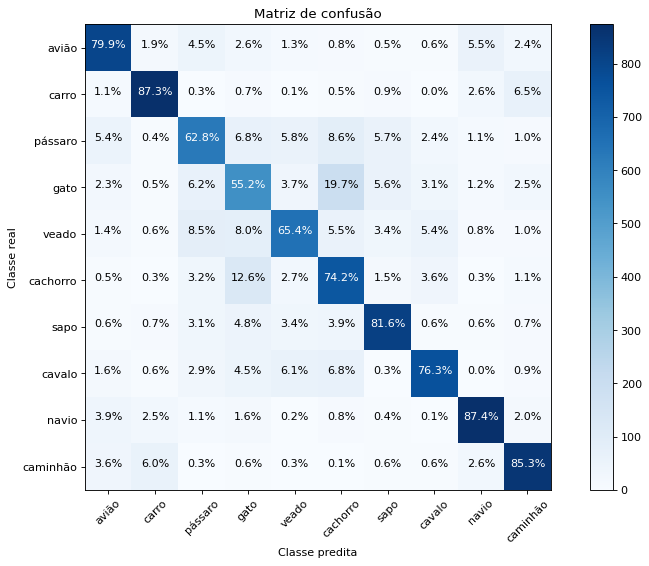

In [55]:
classes = ["avião","carro","pássaro","gato","veado","cachorro","sapo","cavalo","navio","caminhão"]
test(model,x_test,y_test,classes)

# PRUNING alpha=0.75. 
p = pruning, q = quantization, pq = pruning followed by quantization

In [56]:
#cria modelo
model = modelo()
train_compression = Compression(model)
#No compression
train_compression.train(20,train_ds,test_ds,0.75,10,'p')


---------------------Start of epoch 0------------------
Last train values over the epoch: 0
train loss = 1.448230504989624 train acc = 41.645999908447266 sparsity = 57.98575388725543 

test loss = 1.2404837608337402 test accuracy = 51.61000061035156

---------------------Start of epoch 1------------------
Last train values over the epoch: 1
train loss = 1.2286403179168701 train acc = 49.39500045776367 sparsity = 62.26242012144647 

test loss = 0.9955067038536072 test accuracy = 56.43000030517578

---------------------Start of epoch 2------------------
Last train values over the epoch: 2
train loss = 1.5657806396484375 train acc = 54.17466735839844 sparsity = 64.96353499489253 

test loss = 0.9264410734176636 test accuracy = 59.45000076293945

---------------------Start of epoch 3------------------
Last train values over the epoch: 3
train loss = 0.9855929613113403 train acc = 57.65650177001953 sparsity = 66.87312809623619 

test loss = 0.925716757774353 test accuracy = 61.512500762939

Test set accuracy: 73.780%
Confusion matrix, without normalization


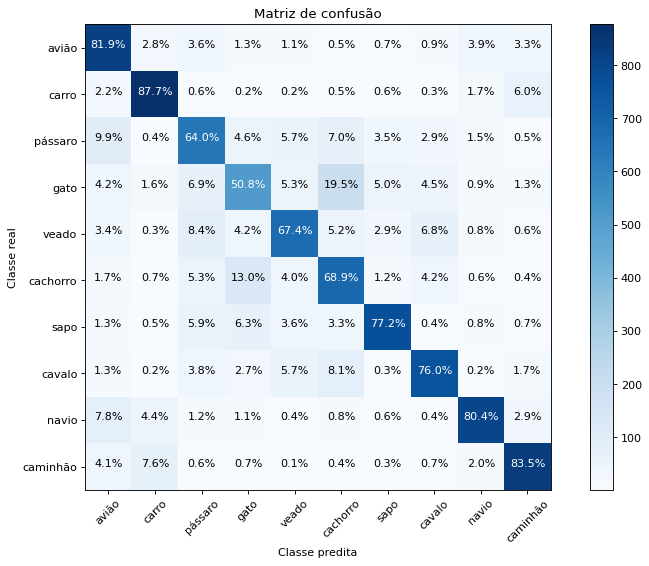

In [57]:
classes = ["avião","carro","pássaro","gato","veado","cachorro","sapo","cavalo","navio","caminhão"]
test(model,x_test,y_test,classes)

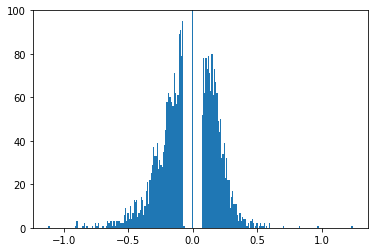

In [81]:

plot_hist(model,"conv2",0,100,250)

# QUANTIZATION 10 bits. 
p = pruning, q = quantization, pq = pruning followed by quantization


In [84]:
#cria modelo
model = modelo()
train_compression = Compression(model)
#No compression
train_compression.train(20,train_ds,test_ds,0.75,10,'q')


---------------------Start of epoch 0------------------
Last train values over the epoch: 0
train loss = 1.25462007522583 train acc = 45.11600112915039 sparsity = 0 

test loss = 1.0482829809188843 test accuracy = 59.10000228881836

---------------------Start of epoch 1------------------
Last train values over the epoch: 1
train loss = 1.8116450309753418 train acc = 54.81200408935547 sparsity = 0 

test loss = 1.168785810470581 test accuracy = 63.2650032043457

---------------------Start of epoch 2------------------
Last train values over the epoch: 2
train loss = 1.1354353427886963 train acc = 60.564666748046875 sparsity = 0 

test loss = 0.8851425647735596 test accuracy = 66.37999725341797

---------------------Start of epoch 3------------------
Last train values over the epoch: 3
train loss = 0.6774134039878845 train acc = 64.5895004272461 sparsity = 0 

test loss = 1.3849860429763794 test accuracy = 67.82500457763672

---------------------Start of epoch 4------------------
Last tr

Test set accuracy: 73.980%
Confusion matrix, without normalization


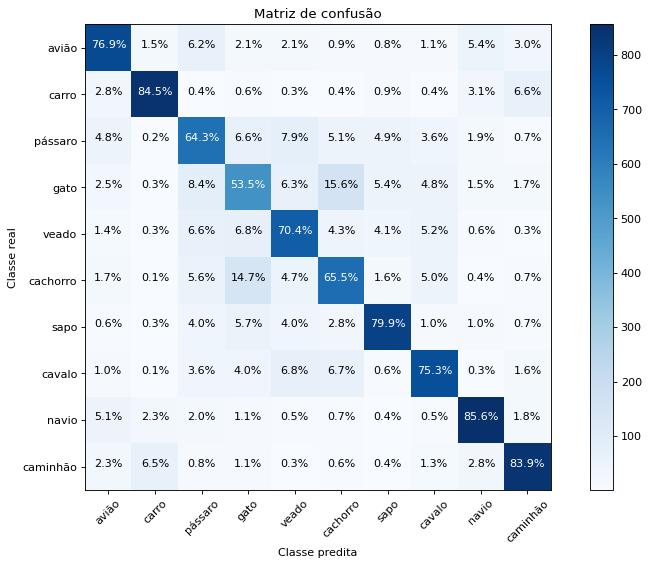

In [85]:
test(model,x_test,y_test,classes)

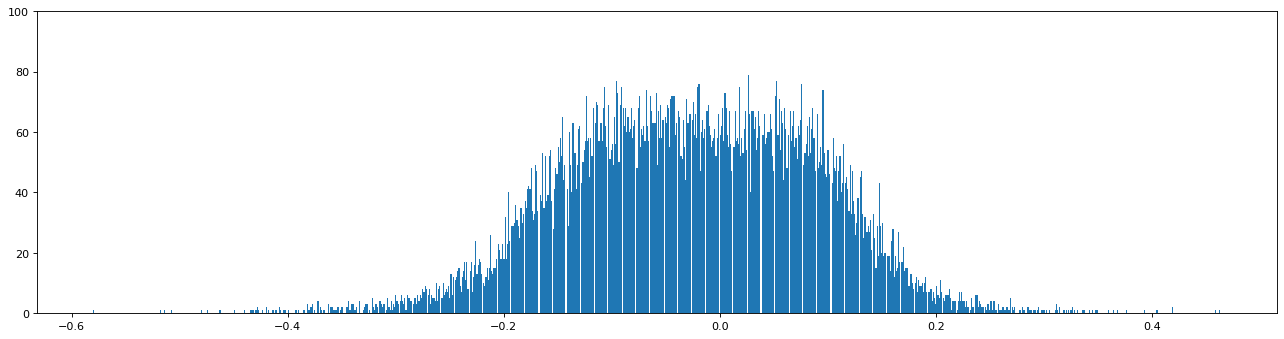

In [104]:
plot_hist(model,"conv2",0,100,1000)

# QUANTIZATION 6 bits. 
p = pruning, q = quantization, pq = pruning followed by quantization

In [106]:
#cria modelo
model = modelo()
train_compression = Compression(model)
#No compression
train_compression.train(20,train_ds,test_ds,0.75,6,'q')


---------------------Start of epoch 0------------------
Last train values over the epoch: 0
train loss = 21077138.0 train acc = 32.12000274658203 sparsity = 0 

test loss = 10208375.0 test accuracy = 33.2599983215332

---------------------Start of epoch 1------------------
Last train values over the epoch: 1
train loss = 1825078912.0 train acc = 32.55099868774414 sparsity = 0 

test loss = 1346298240.0 test accuracy = 33.30500030517578

---------------------Start of epoch 2------------------
Last train values over the epoch: 2
train loss = 14178614272.0 train acc = 32.7053337097168 sparsity = 0 

test loss = 18295822336.0 test accuracy = 33.323333740234375

---------------------Start of epoch 3------------------
Last train values over the epoch: 3
train loss = 290619654144.0 train acc = 32.790000915527344 sparsity = 0 

test loss = 105375924224.0 test accuracy = 33.33250045776367

---------------------Start of epoch 4------------------
Last train values over the epoch: 4
train loss = 

Test set accuracy: 33.330%
Confusion matrix, without normalization


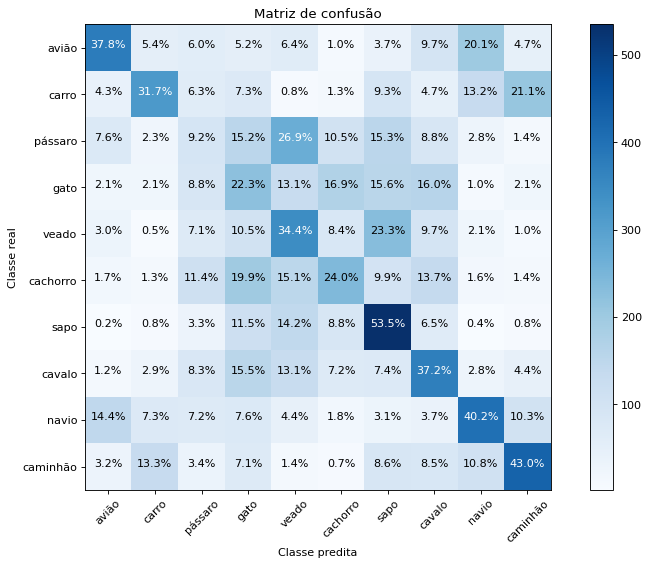

In [107]:
test(model,x_test,y_test,classes)

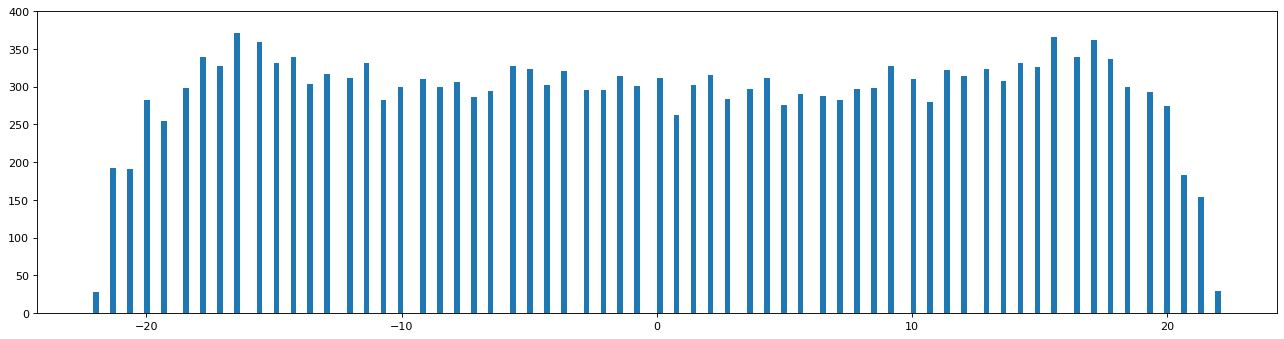

In [113]:
plot_hist(model,"conv2",0,400,200)

# Pruning alpha = 0.75 followed by QUANTIZATION 10 bits. 
p = pruning, q = quantization, pq = pruning followed by quantization

In [114]:
#cria modelo
model = modelo()
train_compression = Compression(model)
#No compression
train_compression.train(20,train_ds,test_ds,0.75,10,'pq')


---------------------Start of epoch 0------------------
Last train values over the epoch: 0
train loss = 1.2680177688598633 train acc = 42.884002685546875 sparsity = 58.24185864625382 

test loss = 1.2024199962615967 test accuracy = 54.77000045776367

---------------------Start of epoch 1------------------
Last train values over the epoch: 1
train loss = 1.1538889408111572 train acc = 50.83500289916992 sparsity = 60.893177910119384 

test loss = 1.223344087600708 test accuracy = 57.744998931884766

---------------------Start of epoch 2------------------
Last train values over the epoch: 2
train loss = 1.2519347667694092 train acc = 55.747337341308594 sparsity = 62.04532953729371 

test loss = 1.0377333164215088 test accuracy = 60.143333435058594

---------------------Start of epoch 3------------------
Last train values over the epoch: 3
train loss = 1.087263822555542 train acc = 59.04849624633789 sparsity = 62.607243296780005 

test loss = 1.1389057636260986 test accuracy = 61.8950004

Test set accuracy: 68.550%
Confusion matrix, without normalization


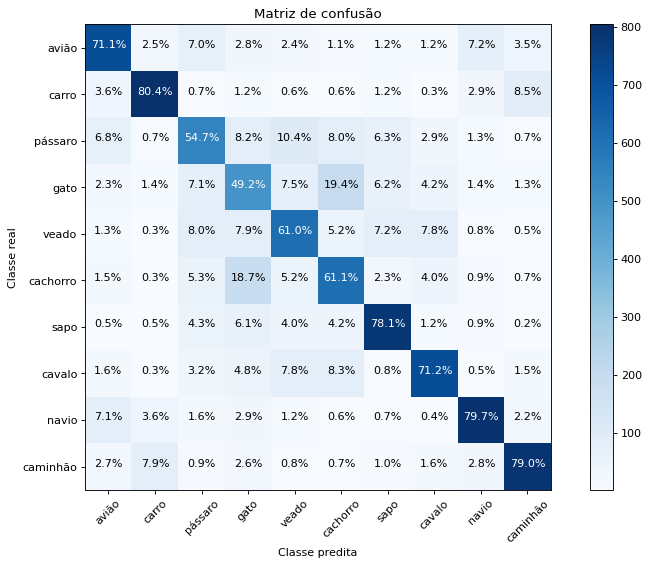

In [115]:
test(model,x_test,y_test,classes)

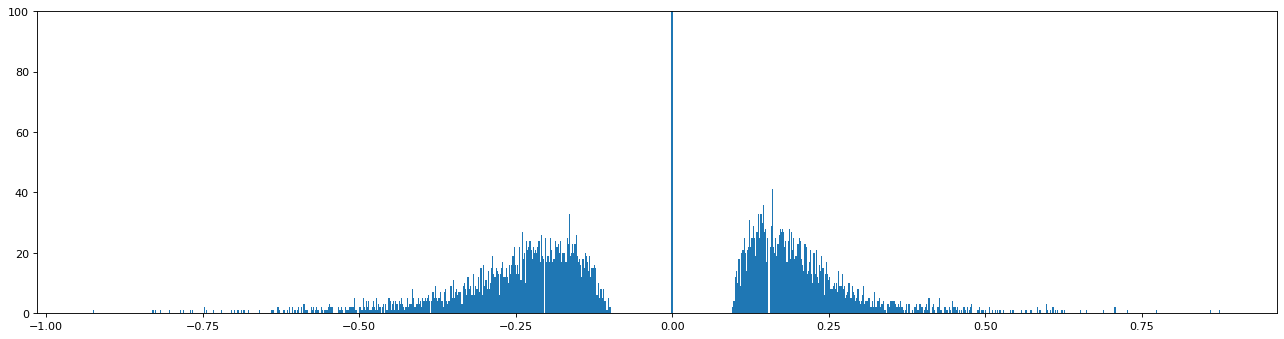

In [116]:
plot_hist(model,"conv2",0,100,1000)

#Outros Testes

In [9]:
#cria modelo
model = modelo()
train_compression = Compression(model)
#No compression
train_compression.train(5,train_ds,test_ds,0.75,3,'pq')


---------------------Start of epoch 0------------------
Last train values over the epoch: 0
train loss = 1312172544.0 train acc = 10.0 sparsity = 51.070103081480234 

test loss = 1532420352.0 test accuracy = 10.0

---------------------Start of epoch 1------------------
Last train values over the epoch: 1
train loss = 304081240064.0 train acc = 10.0 sparsity = 51.070103081480234 

test loss = 218714734592.0 test accuracy = 10.0

---------------------Start of epoch 2------------------
Last train values over the epoch: 2
train loss = 3307697078272.0 train acc = 10.0 sparsity = 51.070103081480234 

test loss = 3054699806720.0 test accuracy = 10.0

---------------------Start of epoch 3------------------
Last train values over the epoch: 3
train loss = 16292581998592.0 train acc = 10.0 sparsity = 51.070103081480234 

test loss = 18065760714752.0 test accuracy = 10.0

---------------------Start of epoch 4------------------
Last train values over the epoch: 4
train loss = 64526191951872.0 tra

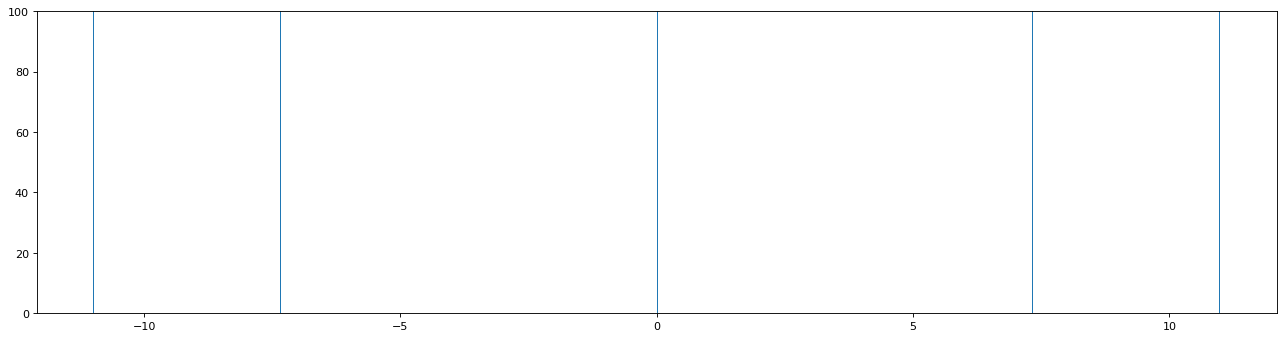

In [10]:
plot_hist(model,"conv2",0,100,1000)

In [11]:
for layer in model.layers:
    if layer.name == 'conv2':
      print(layer.weights[0])

<tf.Variable 'conv2/kernel:0' shape=(3, 3, 32, 64) dtype=float32, numpy=
array([[[[ -7.3298225,  10.994734 ,   0.       , -10.994734 ,
            0.       ,   7.3298225,   0.       ,   0.       ,
           -7.3298225,   0.       ,   7.3298225,  10.994734 ,
            7.3298225, -10.994734 ,   7.3298225,   7.3298225,
            0.       ,   0.       ,   0.       ,  10.994734 ,
           -7.3298225, -10.994734 ,   0.       ,   7.3298225,
            0.       ,  -7.3298225,   0.       ,   7.3298225,
            0.       , -10.994734 ,   0.       ,  -7.3298225,
           10.994734 ,   0.       ,  10.994734 ,   0.       ,
            0.       ,   0.       ,  -7.3298225,   0.       ,
            0.       ,   0.       ,   0.       ,   7.3298225,
            0.       ,   0.       ,   0.       ,   0.       ,
            0.       ,   0.       ,   0.       ,  -7.3298225,
           -7.3298225,   0.       ,  -7.3298225,   0.       ,
           10.994734 ,   0.       ,   0.       ,   0.      